In [1]:
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. 데이터 불러오기

In [2]:
# 유저 데이터
user = pd.read_csv('data/member_mate_sample.csv')

# 프로필 열람 로그 데이터
view = pd.read_pickle('data/view.pickle')

# 관심 있어요 로그 데이터
concern = pd.read_csv('data/concern.csv')

# 영상 통화 로그 데이터
call = pd.read_csv('data/call.csv')

# 동물상 데이터 
animal = pd.read_csv('data/animal.csv')

# 2. 데이터 전처리

## 2-1. 유저 데이터 확인

In [3]:
# 유저 데이터 처리

df_user = user[user['mem_sex'] == 'f']

df_user = df_user[['mem_no', 'mem_sex', 'mem_first_name']]

le = LabelEncoder()
df_user['user'] = le.fit_transform(df_user['mem_no'])

df_user = df_user[['user','mem_no','mem_sex','mem_first_name']]

df_user.sort_values('user', inplace=True)

df_user.reset_index(drop=True, inplace=True)

In [4]:
# mem_no를 넣으면 유저 이름을 반환해 주는 함수

def user_info(n_mem_no):
    if (df_user['user'] == n_mem_no).any():
        return df_user[df_user['user'] == n_mem_no]['mem_no'].iloc[0]
    else:
        return False

In [5]:
# user_info 함수 확인
# user:1 -> mem_no:31

user_info(1)

31

## 2-2. 평점 데이터 생성

- 보유한 로그 데이터를 기반으로 평점을 계산
- 남성 평점 : ((view*1) + (concern*2) + (call*3))
- 여성 평점 : ((view*1) + (concern*1.5) + (call*2))

In [6]:
female_view = view[(view['mem_sex'] == 'f') & (view['ptr_mem_sex'] == 'm')]
female_view['view_weight'] = 1
female_view = female_view[['mem_no','ptr_mem_no','view_weight']]

In [7]:
female_concern = concern[(concern['mem_sex'] == 'f') & (concern['ptr_mem_sex'] == 'm')]
female_concern['concern_weight'] = 1.5
female_concern = female_concern[['mem_no','ptr_mem_no','concern_weight']]

In [8]:
female_call = call[(call['mem_sex'] == 'f') & (call['ptr_mem_sex'] == 'm')]
female_call['call_weight'] = 2.0
female_call = female_call[['mem_no','ptr_mem_no','call_weight']]

In [9]:
# 평점 데이터 생성

merge1 = pd.merge(female_call, female_concern, how='right', on=['mem_no','ptr_mem_no'])

merge2 = pd.merge(merge1, female_view, how='right', on=['mem_no','ptr_mem_no'])

df_rating = merge2.copy()

df_rating['view_weight'].fillna(0, inplace=True)
df_rating['concern_weight'].fillna(0, inplace=True) 
df_rating['call_weight'].fillna(0, inplace=True)

df_rating['rating'] = df_rating['view_weight'] + df_rating['concern_weight'] + df_rating['call_weight']
df_rating = df_rating[['mem_no','ptr_mem_no','rating']]

In [10]:
# 강아지상인 유저만 아이템으로 활용
puppy = animal[animal['animal'] == 'puppy']
puppy.rename(columns={'mem_no' : 'ptr_mem_no'}, inplace=True)

df_puppy = pd.merge(df_rating, puppy, how='right')
df_puppy.dropna(inplace=True)
df_rating = df_puppy

df_rating.drop_duplicates(inplace=True)

# 2-3. 데이터 전처리

In [11]:
le = LabelEncoder()
df_rating['user'] = le.fit_transform(df_rating['mem_no'])

le = LabelEncoder()
df_rating['item'] = le.fit_transform(df_rating['ptr_mem_no'])

In [12]:
# 고유한 유저 수

print("고유한 유저 수 :", df_rating['user'].nunique())
print("유저 id 최소값 :", df_rating['user'].min())
print("유저 id 최대값 :", df_rating['user'].max())

고유한 유저 수 : 6138
유저 id 최소값 : 0
유저 id 최대값 : 6137


In [13]:
# 고유한 아이템 수

print("고유한 유저 수 :", df_rating['item'].nunique())
print("유저 id 최소값 :", df_rating['item'].min())
print("유저 id 최대값 :", df_rating['item'].max())

고유한 유저 수 : 2337
유저 id 최소값 : 0
유저 id 최대값 : 2336


In [14]:
# item 바꾸기 전에 기존 item을 dictionary로 저장해 둔다.

n_unique_item = df_rating['item'].nunique()
item_new2old_dict = dict([(an_index, an_id) for (an_index, an_id) in zip(range(n_unique_item), df_rating['item'].unique())])
item_old2new_dict = dict([(an_id, an_index) for (an_index, an_id) in zip(range(n_unique_item), df_rating['item'].unique())])

In [15]:
# 최소, 최대 평점.

rating_min = df_rating['rating'].min()
rating_max = df_rating['rating'].max()
print("평점 최소값 :", rating_min)
print("평점 최대값 :", rating_max)

평점 최소값 : 1.0
평점 최대값 : 2.5


# 3. tensorflow를 활용한 행렬분해

## 3-1. Simon Funk의 SVD 모델 정의.

In [16]:
N = df_rating['user'].max() + 1    # 유저의 수.
M = df_rating['item'].max() + 1   # 아이템의 수
n_factors = 20                    # 은닉 차원.
mu = df_rating['rating'].mean()

In [17]:
# TensorFlow 모델, Functional API 사용.
u_in = Input(shape=(1,),name = "Input_User")             
m_in = Input(shape=(1,),name = "Input_Movie")
u_mat = Embedding(N, n_factors,name="U_mat")(u_in)
m_mat = Embedding(M, n_factors,name="M_mat")(m_in)
x = Dot(axes=2,name="Dot_Product")([u_mat, m_mat])

In [18]:
u_bias = Embedding(N, 1, name="u_bias")(u_in) 
m_bias = Embedding(M, 1, name="m_bias")(m_in)
x = Add(name="Biases")([x, u_bias, m_bias])

In [19]:
x = Flatten(name="Flatten")(x) 
my_model = Model(inputs=[u_in, m_in], outputs=x)

In [20]:
# 하이퍼 파라미터를 정의
n_epochs = 50
batch_size = 256
learn_rate = 0.0001

In [21]:
# Optimizer 객체 생성 후 컴파일

my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

In [22]:
# 학습

my_EarlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)          # 조기 종료 허락!
history = my_model.fit([df_rating['user'].values, df_rating['item'].values], df_rating['rating'].values - mu , epochs=n_epochs, batch_size = batch_size, validation_split = 0.3, verbose = 0, callbacks=[my_EarlyStop])

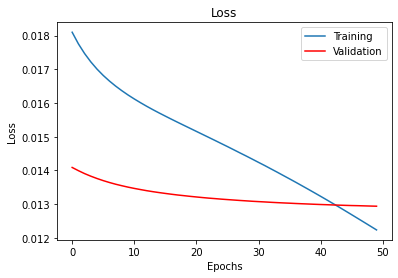

In [23]:
# 모델 평가 
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss)
plt.plot(val_loss, 'r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(["Training", "Validation"])

## 3-2. 예측

In [24]:
# 특정 user에 대한 추천

i_userId = 1
item_ids = df_rating['item'].unique()
user_ids = np.ones(item_ids.size)*i_userId
my_preds = my_model.predict([user_ids, item_ids])
#my_preds = np.clip(my_preds, df_rating['rating'].min(), df_rating['rating'].max())             # 예측된 평점 값이 min~max 구간에 있도록 clipping 해준다.

In [25]:
item_names = [user_info(item_new2old_dict[x]) for x in item_ids]      # 실제 넘버로 변환.
my_predictions = [(x,y) for (x,y) in zip(list(my_preds), item_names)]     # (평점, item) 튜플의 리스트. 

In [26]:
# DataFrame으로 변환 후 출력 준비

df_predicted_ratings = pd.DataFrame(data = my_predictions , columns = ['PredictedRating','item'])
df_predicted_ratings.sort_values(by="PredictedRating", ascending = False, inplace=True)
df_predicted_ratings.reset_index(drop=True, inplace=True)

In [27]:
user_info(1)

31

In [28]:
# mem_no 31인 유저의 추천 결과
# PredictedRating : 예측 평점
# item : 추천된 유저

df_predicted_ratings.head(20)

,PredictedRating,item
0,[0.12227274],638637
1,[0.0872856],753746
2,[0.075633086],505983
3,[0.07525457],1073318
4,[0.062179063],624928
5,[0.058283787],641838
6,[0.058063418],1051743
7,[0.057933107],653780
8,[0.057501916],595058
9,[0.056770742],1126791


In [30]:
df_predicted_ratings.to_csv('data/top20.csv', index=False)